# Memory usage of clipping ops

## Install memory profiler

In [1]:
import urllib.request
response = urllib.request.urlopen("https://raw.githubusercontent.com/yaroslavvb/memory_util/master/memory_util.py")
open("memory_util.py", "wb").write(response.read())

import memory_util
memory_util.vlog(1)
import tensorflow as tf

## Sanity check

In [41]:
from tensorflow.python.ops import gen_random_ops
tf.reset_default_graph()
sess = tf.Session()
dtype = tf.float32
a = gen_random_ops._random_uniform((250*1000,), dtype, name="a")
b = gen_random_ops._random_uniform((250*1000,), dtype, name="b")
c = tf.add(a, b, name="c")
with memory_util.capture_stderr() as stderr:
    sess.run(c.op)
memory_util.print_memory_timeline(stderr, ignore_less_than_bytes=1000)

        7                            a(1555-gpu_bfc)     1000192     1000192 gpu_bfc
        9                            b(1556-gpu_bfc)     1000192     2000384 gpu_bfc
       11                            c(1557-gpu_bfc)     1000192     3000576 gpu_bfc
       13                            a(1555-gpu_bfc)    -1000192     2000384 gpu_bfc
       14                            b(1556-gpu_bfc)    -1000192     1000192 gpu_bfc
       15                            c(1557-gpu_bfc)    -1000192           0 gpu_bfc


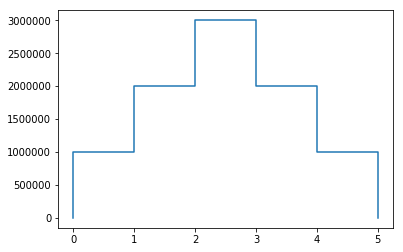

In [42]:
memory_util.plot_memory_timeline(stderr, ignore_less_than_bytes=1000)

## More complex example

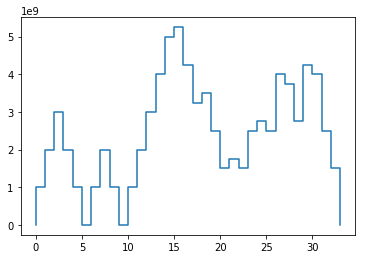

In [40]:
tf.reset_default_graph()
n = 250*1000*1000
dtype = tf.float32
lower = gen_random_ops._random_uniform((n,), dtype, name="l")
upper = gen_random_ops._random_uniform((n,), dtype, name="u")
x = gen_random_ops._random_uniform((n,), dtype, name="x")
sess = tf.Session()
y = tf.minimum(upper, tf.maximum(lower, x, name="cl"), name="cu")
loss = tf.reduce_sum(y, name="loss")
grad = tf.gradients(loss, [x])[0]

with memory_util.capture_stderr() as stderr:
    sess.run(grad.op)
memory_util.plot_memory_timeline(stderr, ignore_less_than_bytes=1000**2)

# Profile memory of a single maximum

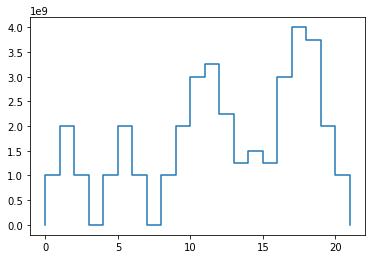

In [35]:
tf.reset_default_graph()
n = 250*1000*1000
dtype = tf.float32
upper = gen_random_ops._random_uniform((n,), dtype, name="u")
x = gen_random_ops._random_uniform((n,), dtype, name="x")
sess = tf.Session()
y = tf.minimum(upper, x, name="cu")
loss = tf.reduce_sum(y, name="loss")
grad = tf.gradients(loss, [x])[0]

with memory_util.capture_stderr() as stderr:
    sess.run(grad.op)
memory_util.plot_memory_timeline(stderr, ignore_less_than_bytes=1000**2)

# Profile memory of a chain of max

In [29]:
def memory_req_minimum(chain_length):
    """Returns memory req to compute chain of min ops"""
    tf.reset_default_graph()
    n = 250*1000*1000
    dtype = tf.float32
    upper = gen_random_ops._random_uniform((n,), dtype, name="u")
    x = gen_random_ops._random_uniform((n,), dtype, name="x")
    sess = tf.Session()
    y = x
    for i in range(chain_length):
        y = tf.minimum(upper, y, name="cu")
    loss = tf.reduce_sum(y, name="loss")
    grad = tf.gradients(loss, [x])[0]

    with memory_util.capture_stderr() as stderr:
        sess.run(grad.op)
    return memory_util.peak_memory(stderr)

In [32]:
print("%12s %12s" %("Chain length", "mem req"))
for i in range(10):
    print("%12d %12d"%(i, memory_req_minimum(i)))

Chain length      mem req
           0   1000001024
           1   4000001024
           2   4250001408
           3   4750001408
           4   5750001408
           5   6000001536
           6   7000000120
           7   8000000136
           8   9000000152
           9  10000000168


# Profile memory of chain on min/max ops

In [33]:
def memory_req_minmax(chain_length):
    """Returns memory req to compute chain of min ops"""
    tf.reset_default_graph()
    n = 250*1000*1000
    dtype = tf.float32
    upper = gen_random_ops._random_uniform((n,), dtype, name="u")
    
    x = gen_random_ops._random_uniform((n,), dtype, name="x")
    sess = tf.Session()
    y = x
    for i in range(chain_length):
        y = tf.minimum(upper, tf.maximum(upper, y, name="cl"), name="cu")
    loss = tf.reduce_sum(y, name="loss")
    grad = tf.gradients(loss, [x])[0]

    with memory_util.capture_stderr() as stderr:
        sess.run(grad.op)
    return memory_util.peak_memory(stderr)

In [34]:
print("%12s %12s" %("Chain length", "mem req"))
for i in range(10):
    print("%12d %12d"%(i, memory_req_minmax(i)))

Chain length      mem req
           0   1000001024
           1   4250001408
           2   5750001408
           3   7000000120
           4   9000000152
           5  11000000184
           6  13000000212
           7  15000000248
           8  17000000280
           9  19000000312


# Clipping using map_fn

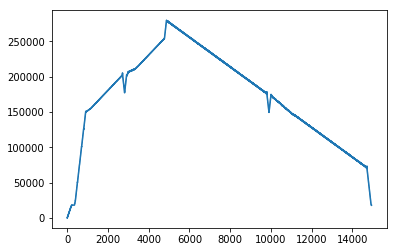

In [66]:
tf.reset_default_graph()
n = 100#250*1000*1000
dtype = tf.float32
lower = gen_random_ops._random_uniform((n,), dtype, name="u")
upper = gen_random_ops._random_uniform((n,), dtype, name="u")
x = gen_random_ops._random_uniform((n,), dtype, name="x")
sess = tf.Session(config = tf.ConfigProto(graph_options=tf.GraphOptions(optimizer_options=tf.OptimizerOptions(opt_level=tf.OptimizerOptions.L0))))

y = x
#chain_length = 2
for i in range(chain_length):
    y = tf.map_fn(lambda args: tf.clip_by_value(args[0], args[1], args[2]), (y, lower, upper), dtype=(dtype))
    loss = tf.reduce_sum(y, name="loss")
    grad = tf.gradients(loss, [x])[0]

with memory_util.capture_stderr() as stderr:
    sess.run(grad.op)
memory_util.plot_memory_timeline(stderr, ignore_less_than_bytes=0)

In [71]:
def memory_req_mapfn(chain_length):
    """Returns memory req to compute chain of min ops"""
    tf.reset_default_graph()
    n = 250
    dtype = tf.float32
    upper = gen_random_ops._random_uniform((n,), dtype, name="u")
    lower = gen_random_ops._random_uniform((n,), dtype, name="l")
    
    x = gen_random_ops._random_uniform((n,), dtype, name="x")
    sess = tf.Session()
    y = x
    for i in range(chain_length):
        y = tf.map_fn(lambda args: tf.clip_by_value(args[0], args[1], args[2]), (y, lower, upper), dtype=(dtype))
    loss = tf.reduce_sum(y, name="loss")
    grad = tf.gradients(loss, [x])[0]

    with memory_util.capture_stderr() as stderr:
        sess.run(grad.op)
    return memory_util.peak_memory(stderr)

In [72]:
print("%12s %12s" %("Chain length", "mem req"))
for i in range(10):
    print("%12d %12d"%(i, memory_req_mapfn(i)))

Chain length      mem req
           0         2048
           1       391856
           2       653435
           3       914501
           4      1175823
           5      1437145
           6      1697698
           7      1960045
           8      2221111
           9      2482433


In [73]:
!pwd

/home/yaroslav/git2/notebooks
